# Data exploration

This notebook is dedicated to the analysis of a part of the Enron email dataset. The goal is to go through the data, extract miminum viable features and train a classification algorithm on it. If results are not good enough, extract more information and so on.

Here the classification task is to find professional and personal emails.

In [1]:
import os
import re
import csv
import pandas as pd
import email
import matplotlib.pyplot as plt
%matplotlib inline

from utils.tokenizer import *

In [2]:
sup_path = './data/sup/'
unsup_path = './data/unsup/'
business_path = sup_path + 'business/'
personal_path = sup_path + 'personal/'
encoding = 'utf-8'

# Create a emails.csv file for faster work
if not os.path.isfile(sup_path+'emails.csv'):
    with open(sup_path+'emails.csv', 'w', encoding=encoding, newline= '') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=['file', 'message', 'label'], delimiter =',', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
        writer.writeheader()
        # Open professionl emails
        label=0
        for filename in os.listdir(business_path):
            with open(business_path+filename, 'r', encoding=encoding) as f:
                writer.writerow({'file': filename, 'message': f.read(), 'label':label})
        # Open personal emails
        label=1
        for filename in os.listdir(personal_path):
            try:
                with open(personal_path+filename, 'r', encoding=encoding) as f:
                    writer.writerow({'file': filename, 'message': f.read(), 'label':label})
            # Encoding exception
            except:
                with open(personal_path+filename, 'r', encoding='ansi') as f:
                    writer.writerow({'file': filename, 'message': f.read(), 'label':label})
        

In [3]:
# Read the supervised data into a DataFrame
emails = pd.read_csv(sup_path+'emails.csv')
print('Total of %d emails in the supervised dataset'% (emails.shape[0]))
emails.head()

Total of 6385 emails in the supervised dataset


,file,message,label
0,maildir_allen-p_inbox_23,"Date: Tue, 23 Oct 2001 15:14:37 -0700 (PDT)\nF...",0
1,maildir_allen-p_inbox_84,"Date: Mon, 26 Nov 2001 08:31:11 -0800 (PST)\nF...",0
2,maildir_allen-p_inbox_85,"Date: Mon, 26 Nov 2001 15:33:45 -0800 (PST)\nF...",0
3,maildir_allen-p_notes_inbox_32,"Date: Tue, 12 Dec 2000 23:04:00 -0800 (PST)\nF...",0
4,maildir_allen-p_notes_inbox_39,"Date: Thu, 7 Dec 2000 01:55:00 -0800 (PST)\nFr...",0


In [4]:
emails.drop_duplicates()
print('Total of %d emails in the supervised dataset'% (emails.shape[0]))

Total of 6385 emails in the supervised dataset


The whole content of the emails are in the 'message'column, it will then be necessary to parse it to extract information

### Email Parsing

In [5]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def get_domains(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        domains = []
        for addr in addrs:
            try:
                # seperate users and domain to create categorical data later-on (ex: 0 for non enron mail, 1 else)
                domain = addr.split('@')[1]
                domains.append(domain.strip())
            except:
                print(addr)
        addrs = domains
    else:
        addrs = frozenset()
    return frozenset(map(lambda x: x.strip(), addrs))

def get_users(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        users = []
        for addr in addrs:
            try:
                # seperate users and domain to create categorical data later-on (ex: 0 for non enron mail, 1 else)
                user = addr.split('@')[0]
                users.append(user.strip())
            except:
                print(addr)
        addrs = users
    else:
        addrs = frozenset()
    return frozenset(map(lambda x: x.strip(), addrs))

In [6]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6385 entries, 0 to 6384
Data columns (total 3 columns):
file       6385 non-null object
message    6385 non-null object
label      6385 non-null int64
dtypes: int64(1), object(2)
memory usage: 149.7+ KB


In [7]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails['message']))
emails.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails[key] = [doc[key] for doc in messages]
    
# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))

# Parse date to have categorical data
dates = pd.to_datetime(emails['Date'], infer_datetime_format=True)
emails['Year'] = dates.dt.year
emails['DayOfWeek'] = dates.dt.dayofweek
emails['Hour'] = dates.dt.hour

# Split multiple email addresses
emails['FromDomain'] = emails['From'].map(get_domains)
emails['FromUser'] = emails['From'].map(get_users)
emails['ToDomain'] = emails['To'].map(get_domains)
emails['ToUser'] = emails['To'].map(get_users)
emails.drop(['From', 'To'], axis=1, inplace=True)

del messages
del dates

emails.loc[:emails.shape[0], 'user'] = emails.loc[:emails.shape[0], 'file'].map(lambda x:x.split('-')[0])

emails.head()

e-mail <mari.>
 e-mail <gretchen.>


,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user
0,maildir_allen-p_inbox_23,0,"Tue, 23 Oct 2001 15:14:37 -0700 (PDT)",Properties for sale,PALLEN (Non-Privileged).pst,There are three other deals that I will fax to...,2001.0,1.0,22.0,(austintx.com),(jsmith),(enron.com),(k..allen),maildir_allen
1,maildir_allen-p_inbox_84,0,"Mon, 26 Nov 2001 08:31:11 -0800 (PST)",Answer,PALLEN (Non-Privileged).pst,For purposes of an accelerated distribution fr...,2001.0,0.0,16.0,(enron.com),(david.oxley),(enron.com),(k..allen),maildir_allen
2,maildir_allen-p_inbox_85,0,"Mon, 26 Nov 2001 15:33:45 -0800 (PST)",Wednesday Meeting,PALLEN (Non-Privileged).pst,"Phillip,\n\nI will get a room for our Wednesda...",2001.0,0.0,23.0,(accenture.com),(mery.l.brown),(enron.com),(pallen),maildir_allen
3,maildir_allen-p_notes_inbox_32,0,"Tue, 12 Dec 2000 23:04:00 -0800 (PST)",New Notice from Transwestern Pipeline Co.,pallen.nsf,Transwestern Pipeline Co. posted new notice(s)...,2000.0,2.0,7.0,(enron.com),(critical.notice),(enron.com),"(phillip.k.allen, ywang, patti.sullivan, jane....",maildir_allen
4,maildir_allen-p_notes_inbox_39,0,"Thu, 7 Dec 2000 01:55:00 -0800 (PST)",System Development,pallen.nsf,Can you please review the following systems pr...,2000.0,3.0,9.0,(enron.com),(tiffany.miller),(enron.com),"(phillip.allen, barry.tycholiz)",maildir_allen


In [8]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6385 entries, 0 to 6384
Data columns (total 14 columns):
file          6385 non-null object
label         6385 non-null int64
Date          6362 non-null object
Subject       6362 non-null object
X-FileName    6362 non-null object
content       6385 non-null object
Year          6362 non-null float64
DayOfWeek     6362 non-null float64
Hour          6362 non-null float64
FromDomain    6385 non-null object
FromUser      6385 non-null object
ToDomain      6385 non-null object
ToUser        6385 non-null object
user          6385 non-null object
dtypes: float64(3), int64(1), object(10)
memory usage: 698.4+ KB


In [9]:
# Find number of unique values in each columns
for col in emails.columns:
    if col != 'From' and col != 'To':
        print(col, emails[col].nunique())

file 6385
label 2
Date 6208
Subject 5617
X-FileName 348
content 6363
Year 4
DayOfWeek 7
Hour 24
FromDomain 622
FromUser 2392
ToDomain 611
ToUser 3100
user 248


### Data cleansing

Checking fo outliers.

In [10]:
emails[[Subject == None for i, Subject in enumerate(emails['Subject'])]]

,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user
5074,maildir_baughman-d_personal_letters_42,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_baughman
5342,maildir_farmer-d_personal_129,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_farmer
5343,maildir_farmer-d_personal_16,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_farmer
5370,maildir_farmer-d_personal_295,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_farmer
5426,maildir_germany-c_personal_44,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_germany
5545,maildir_hyatt-k_personal_100,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_hyatt
5598,maildir_kaminski-v_personal_131,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_kaminski
5605,maildir_kaminski-v_personal_274,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_kaminski
5616,maildir_kaminski-v_personal_323,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_kaminski
5617,maildir_kaminski-v_personal_337,1,None,None,None,<MARKUP id=alex Time=Mon Feb 05 16:02:58 GMT 2...,NaN,NaN,NaN,(),(),(),(),maildir_kaminski


Most of the columns are empty for these lines, so it's preferable to drop them

In [11]:
emails.drop([i for i, Subject in enumerate(emails['Subject']) if Subject == None], inplace=True)

In [12]:
emails[[file == None for i, file in enumerate(emails['X-FileName'])]]

,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user


In [13]:
emails[[user == None for i, user in enumerate(emails['user'])]]

,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user


# Tokenize

Now it's time to tokenize the content and Subject. The tokenizer used is Spacy. No Part of Speech neither Named entity were used, but could have been insteresting with more data or more complex labeling.

In [14]:
from utils.tokenizer import corpus, to_BoW, get_vocab, index_corpus

In [15]:
subjects_corpus = corpus(emails['Subject'], stop_words = False)
emails['Subjects_indexed'] = subjects_corpus.indexed

100%|████████████████████████████████████████████████████████████████████████████| 6362/6362 [00:02<00:00, 2491.70it/s]


In [16]:
contents_corpus = corpus(emails['content'], stop_words = False)
emails['content_indexed'] = contents_corpus.indexed

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:06<00:00, 50.36it/s]


## Emails content lengths

If the contents are going to be used for the classifier, the length play a big part in the decision of the algorithm.
Indeed, Recurrent Neural Network, for example, start to be less interesting after ~100 tokens, plus, the training time can get pretty long.

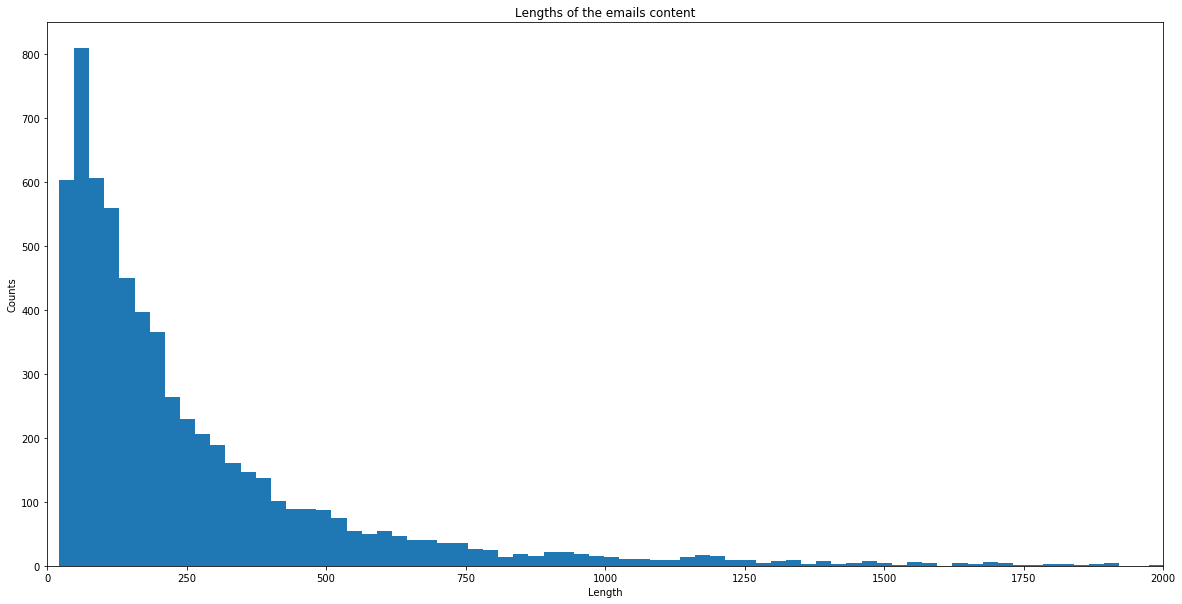

In [17]:
import matplotlib.pyplot as plt

lengths = [len(content) for content in emails['content_indexed']]

plt.figure(figsize=(20,10))
plt.hist(lengths, bins='auto') 
plt.xlim((0,2000))
plt.title('Lengths of the emails content')
plt.ylabel('Counts')
plt.xlabel('Length')
plt.show()

In [18]:
users = get_vocab(emails['FromUser'].tolist() + emails['ToUser'].tolist())
domains = get_vocab(emails['FromDomain'].tolist() + emails['ToDomain'].tolist())

In [19]:
FromUsers = to_BoW(index_corpus(emails['FromUser'].tolist(), users), users)
ToUsers = to_BoW(index_corpus(emails['ToUser'].tolist(), users), users)
FromDomains = to_BoW(index_corpus(emails['FromDomain'].tolist(), domains), domains)
ToDomains = to_BoW(index_corpus(emails['ToDomain'].tolist(), domains), domains)

Save the vocabularies and Bag of Words

In [20]:
from scipy.sparse import save_npz

save_npz('./data/FromUsers.npz',FromUsers)
save_npz('./data/ToUsers.npz',ToUsers)
save_npz('./data/FromDomains.npz',FromDomains)
save_npz('./data/ToDomains.npz',ToDomains)

vocab = subjects_corpus.vocab[:]
for i, idf in enumerate(subjects_corpus.idf):
    vocab[i] += (idf, )
with open('./data/Subjects_vocab.csv', 'w', newline='', encoding=encoding) as f:
    csv_writer = csv.writer(f, delimiter =',', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
    csv_writer.writerow(['word', 'count', 'idf'])
    csv_writer.writerows(vocab)
save_npz('./data/subjects_BoW.npz',subjects_corpus.BoW)
    
vocab = contents_corpus.vocab[:]
for i, idf in enumerate(contents_corpus.idf):
    vocab[i] += (idf, )
with open('./data/contents_vocab.csv', 'w', newline='', encoding=encoding) as f:
    csv_writer = csv.writer(f, delimiter =',', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
    csv_writer.writerow(['word', 'count', 'idf'])
    csv_writer.writerows(vocab)
save_npz('./data/contents_BoW.npz',contents_corpus.BoW)

In [21]:
emails.to_pickle('./data/emails.pkl')